In [1]:
import torch
import os

# Verificar GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [2]:
import os
from PIL import Image
import numpy as np


def process_transparent_mask(mask_path):
    """
    Convierte una máscara RGB con transparencia a una máscara binaria (blanco y negro).
    Args:
        mask_path (str): Ruta a la máscara RGB con transparencia.
    Returns:
        np.array: Máscara binaria.
    """
    # Cargar la máscara en modo RGBA para incluir el canal alfa
    mask = Image.open(mask_path).convert("RGBA")
    mask_np = np.array(mask)

    # Extraer el canal alfa
    alpha_channel = mask_np[:, :, 3]

    # Binarizar el canal alfa (0: fondo, 255: mano)
    binary_mask = (alpha_channel > 127).astype(np.uint8) * 255

    return binary_mask


def preprocess_transparent_masks(input_dir, output_dir):
    """
    Preprocesa máscaras RGB con transparencia y las convierte en máscaras binarias.
    Args:
        input_dir (str): Directorio con máscaras originales (RGB con transparencia).
        output_dir (str): Directorio donde se guardarán las máscaras binarias.
    """
    os.makedirs(output_dir, exist_ok=True)

    for mask_name in os.listdir(input_dir):
        mask_path = os.path.join(input_dir, mask_name)

        if mask_name.endswith(('.png', '.jpg', '.jpeg')):
            binary_mask = process_transparent_mask(mask_path)

            # Guardar la máscara binaria como PNG
            output_path = os.path.join(output_dir, mask_name)
            Image.fromarray(binary_mask).save(output_path)
            #print(f"Procesada y guardada: {output_path}")


# Directorios para train, val y test
data_dirs = {
    "train": {
        "input": "../data/train/masks",
        "output": "../data/train/cleaned_masks"
    },
    "val": {
        "input": "../data/val/masks",
        "output": "../data/val/cleaned_masks"
    },
    "test": {
        "input": "../data/test/masks",
        "output": "../data/test/cleaned_masks"
    }
}

# Procesar máscaras de todos los conjuntos
for dataset, dirs in data_dirs.items():
    print(f"Preprocesando máscaras de {dataset}...")
    preprocess_transparent_masks(dirs["input"], dirs["output"])
    print(f"Máscaras de {dataset} procesadas y guardadas en {dirs['output']}\n")


Preprocesando máscaras de train...
Máscaras de train procesadas y guardadas en ../data/train/cleaned_masks

Preprocesando máscaras de val...
Máscaras de val procesadas y guardadas en ../data/val/cleaned_masks

Preprocesando máscaras de test...
Máscaras de test procesadas y guardadas en ../data/test/cleaned_masks



In [3]:
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Definir las transformaciones para imágenes y máscaras
class SegmentationTransform:
    def __init__(self, input_size):
        self.image_transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),  # Redimensionar a tamaño fijo
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],  # Normalización para imágenes preentrenadas
                                 [0.229, 0.224, 0.225])  # Convertir a tensor
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),  # Redimensionar máscaras
            transforms.ToTensor()  # Convertir a tensor
        ])

    def __call__(self, image, mask):
        image = self.image_transform(image)
        mask = self.mask_transform(mask)
        return image, mask

# Dataset personalizado para segmentación
class HandSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg'))])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.image_files[idx].replace('_image', '_mask').rsplit(".", 1)[0] + ".png")

        # Cargar imagen y máscara
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Escala de grises

        # Aplicar transformaciones
        if self.transform:
            image, mask = self.transform(image, mask)

        # Binarizar máscara a [0,1]
        mask = (mask > 0.5).float()

        return image, mask

datasets = {
    'train': HandSegmentationDataset(
        images_dir="../data/train/images",
        masks_dir="../data/train/cleaned_masks",  # Rutas actualizadas
        transform=SegmentationTransform(input_size=512)  # Transformaciones de Torch
    ),
    'val': HandSegmentationDataset(
        images_dir="../data/val/images",
        masks_dir="../data/val/cleaned_masks",  # Rutas actualizadas
        transform=SegmentationTransform(input_size=512)
    ),
    'test': HandSegmentationDataset(
        images_dir="../data/test/images",
        masks_dir="../data/test/cleaned_masks",  # Rutas actualizadas
        transform=SegmentationTransform(input_size=512)
    )
}

batch_size = 4
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=batch_size,
        shuffle=(x == 'train'),
    )
    for x in ['train', 'val', 'test']
}


In [4]:
# Celda: Definición del modelo DeepLabV3+ con ResNet-101
import segmentation_models_pytorch as smp

# Modelo DeepLabV3+ con ResNet101 como backbone
model = smp.DeepLabV3Plus(
    encoder_name="resnet101",       # Encoder más avanzado
    encoder_weights="imagenet",    # Pesos preentrenados en ImageNet
    in_channels=3,                 # 3 canales de entrada (RGB)
    classes=1,                     # Salida binaria (1 canal para segmentación)
    activation=None                # Sin activación final, usamos logits
).to(device)

# Congelar capas iniciales del encoder (transfer learning)
for name, param in model.encoder.named_parameters():
    if "layer4" not in name:  # Solo descongelar la última capa del encoder
        param.requires_grad = False

# Definir la función de pérdida
loss_fn = torch.nn.BCEWithLogitsLoss()

# Optimizador con learning rates específicos
optimizer = torch.optim.AdamW([
    {"params": model.encoder.layer4.parameters(), "lr": 1e-5},  # Learning rate bajo para capas descongeladas
    {"params": model.decoder.parameters(), "lr": 1e-4},        # Learning rate para el decoder
    {"params": model.segmentation_head.parameters(), "lr": 1e-4},  # Cabeza de segmentación
])

C:\Users\Bootcamp\anaconda3\envs\computer_vision\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\Bootcamp/.cache\torch\hub\checkpoints\resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 68.2MB/s] 


In [5]:
# Calcular la accuracy
def calculate_accuracy(preds, masks):
    """
    Calcula la accuracy para segmentación binaria.
    Args:
        preds: Tensor de predicciones (logits o probabilidades binarizadas).
        masks: Tensor de máscaras reales.
    Returns:
        float: Accuracy en el batch.
    """
    preds = (torch.sigmoid(preds) > 0.5).float()  # Binarizar predicciones
    correct = (preds == masks).sum().item()      # Píxeles correctamente clasificados
    total = torch.numel(preds)                   # Total de píxeles
    return correct / total

def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Forward
        logits = model(images)
        loss = loss_fn(logits, masks)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular loss y accuracy
        running_loss += loss.item()
        running_acc += calculate_accuracy(logits, masks)

    return running_loss / len(dataloader), running_acc / len(dataloader)

@torch.no_grad()
def validate_one_epoch(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Forward
        logits = model(images)
        loss = loss_fn(logits, masks)

        # Calcular loss y accuracy
        running_loss += loss.item()
        running_acc += calculate_accuracy(logits, masks)

    return running_loss / len(dataloader), running_acc / len(dataloader)


In [6]:
# Parámetros de entrenamiento
num_epochs = 30
patience = 7  # Mayor paciencia para transfer learning
early_stop_counter = 0
best_val_loss = float("inf")
best_model_path = "../data/model/best_model_resnet101.pth"
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)

# Entrenamiento con early stopping
for epoch in range(num_epochs):
    # Entrenamiento
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], optimizer, loss_fn, device)

    # Validación
    val_loss, val_acc = validate_one_epoch(model, dataloaders['val'], loss_fn, device)

    # Imprimir métricas
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Imprimir learning rates (opcional)
    for param_group in optimizer.param_groups:
        print(f"Learning Rate: {param_group['lr']}")

    # Guardar el mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  --> Guardado mejor modelo con Val Loss: {best_val_loss:.4f}")
        early_stop_counter = 0  # Reiniciar el contador de paciencia
    else:
        early_stop_counter += 1  # Incrementar el contador

    # Detener si no mejora por 'patience' épocas
    if early_stop_counter >= patience:
        print(f"Early stopping activado. No hubo mejora en {patience} épocas consecutivas.")
        break


Epoch [1/30]
  Train Loss: 0.4536, Train Accuracy: 0.8414
  Val Loss: 0.5049, Val Accuracy: 0.9119
Learning Rate: 1e-05
Learning Rate: 0.0001
Learning Rate: 0.0001
  --> Guardado mejor modelo con Val Loss: 0.5049
Epoch [2/30]
  Train Loss: 0.2599, Train Accuracy: 0.9272
  Val Loss: 0.2596, Val Accuracy: 0.9344
Learning Rate: 1e-05
Learning Rate: 0.0001
Learning Rate: 0.0001
  --> Guardado mejor modelo con Val Loss: 0.2596
Epoch [3/30]
  Train Loss: 0.1853, Train Accuracy: 0.9519
  Val Loss: 0.1806, Val Accuracy: 0.9497
Learning Rate: 1e-05
Learning Rate: 0.0001
Learning Rate: 0.0001
  --> Guardado mejor modelo con Val Loss: 0.1806
Epoch [4/30]
  Train Loss: 0.1493, Train Accuracy: 0.9641
  Val Loss: 0.1580, Val Accuracy: 0.9597
Learning Rate: 1e-05
Learning Rate: 0.0001
Learning Rate: 0.0001
  --> Guardado mejor modelo con Val Loss: 0.1580
Epoch [5/30]
  Train Loss: 0.1243, Train Accuracy: 0.9720
  Val Loss: 0.1344, Val Accuracy: 0.9694
Learning Rate: 1e-05
Learning Rate: 0.0001
Learni

In [7]:
def calculate_iou(preds, targets):
    """
    Calcula el Intersection over Union (IoU) entre las predicciones y los valores reales.
    Args:
        preds (torch.Tensor): Tensor binario de predicciones (1 para objeto, 0 para fondo).
        targets (torch.Tensor): Tensor binario de máscaras reales.
    Returns:
        float: Valor del IoU (promedio por batch).
    """
    # Asegurarse de que las entradas son binarias
    preds = preds.int()
    targets = targets.int()
    
    # Calcular intersección y unión
    intersection = (preds & targets).float().sum((1, 2, 3))  # Suma por batch
    union = (preds | targets).float().sum((1, 2, 3))         # Suma por batch

    # Evitar división por cero
    iou = (intersection / union).mean().item()  # Promedio por batch
    return iou


In [8]:
def evaluate_model(model, dataloader, device):
    """
    Evalúa el modelo utilizando IoU y precisión media.
    Args:
        model: Modelo entrenado.
        dataloader: DataLoader del conjunto de prueba.
        device: 'cuda' o 'cpu'.
    """
    model.eval()
    iou_total = 0
    accuracy_total = 0
    num_samples = 0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Convertir logits a binario
            
            # Calcular métricas
            iou = calculate_iou(preds, masks)
            accuracy = (preds == masks).float().mean().item()
            
            iou_total += iou
            accuracy_total += accuracy
            num_samples += 1
    
    print(f"Mean IoU: {iou_total / num_samples:.4f}, Mean Accuracy: {accuracy_total / num_samples:.4f}")

evaluate_model(model, dataloaders['test'], device)

Mean IoU: 0.9011, Mean Accuracy: 0.9769


In [9]:
def denormalize_image(image_tensor, mean, std):
    """
    Desnormaliza un tensor de imagen para visualización.
    Args:
        image_tensor (torch.Tensor): Tensor de imagen normalizada (C, H, W).
        mean (list): Lista con las medias utilizadas para normalización.
        std (list): Lista con las desviaciones estándar utilizadas para normalización.
    Returns:
        np.array: Imagen desnormalizada en formato numpy (H, W, C).
    """
    image = image_tensor.clone().cpu().numpy()
    for i in range(image.shape[0]):  # Desnormalizar cada canal (C)
        image[i] = (image[i] * std[i]) + mean[i]
    image = np.clip(image, 0, 1)  # Asegurar que los valores estén en [0, 1]
    return np.transpose(image, (1, 2, 0))  # Cambiar a formato (H, W, C)


In [10]:
def remove_background_with_predicted_mask(image, pred_mask):
    """
    Elimina el fondo de una imagen utilizando la máscara predicha.
    Args:
        image (np.array): Imagen RGB desnormalizada (H, W, C).
        pred_mask (np.array): Máscara predicha binaria (H, W) con valores 0 o 1.
    Returns:
        np.array: Imagen con el fondo eliminado.
    """
    # Asegurar que la máscara es binaria
    pred_mask = (pred_mask > 0.5).astype(np.float32)  # Valores 0 y 1

    # Expandir la máscara a tres canales para aplicarla a la imagen RGB
    mask_rgb = np.stack([pred_mask] * 3, axis=-1)  # (H, W) -> (H, W, 3)

    # Aplicar la máscara a la imagen
    image_with_mask = image * mask_rgb

    return image_with_mask


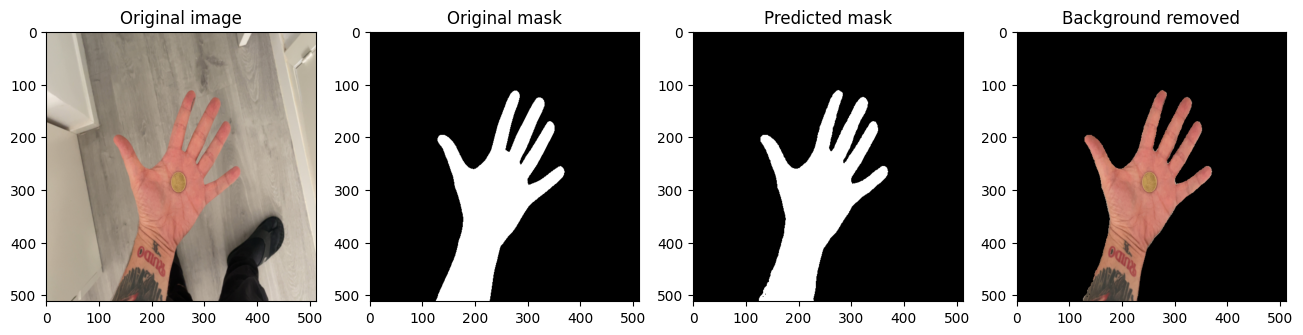

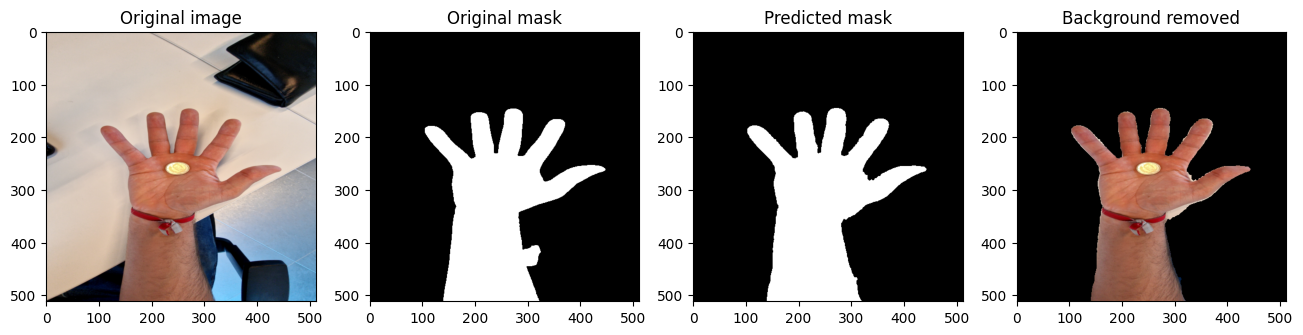

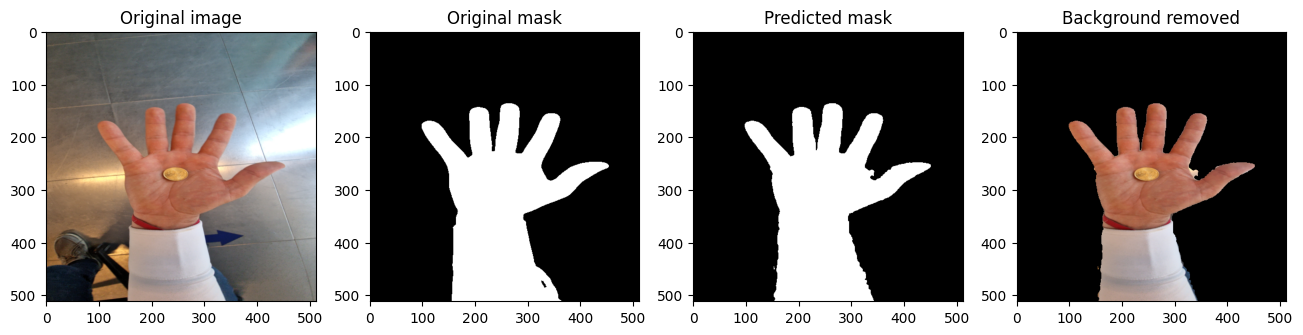

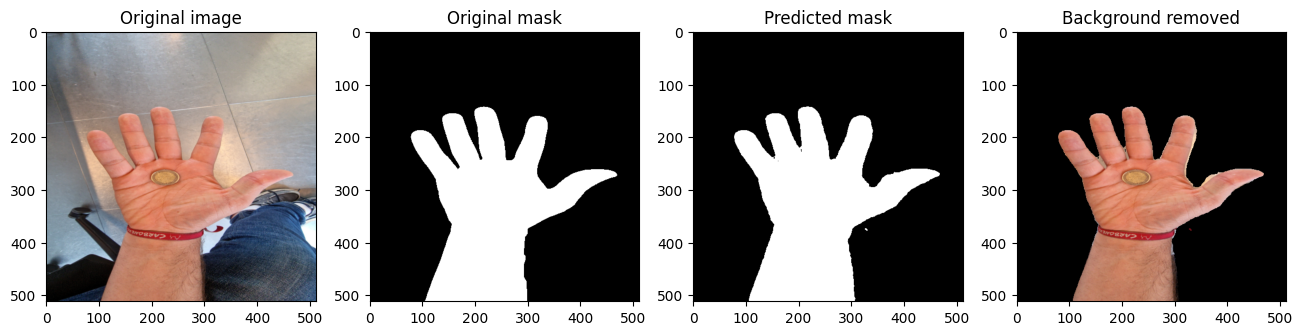

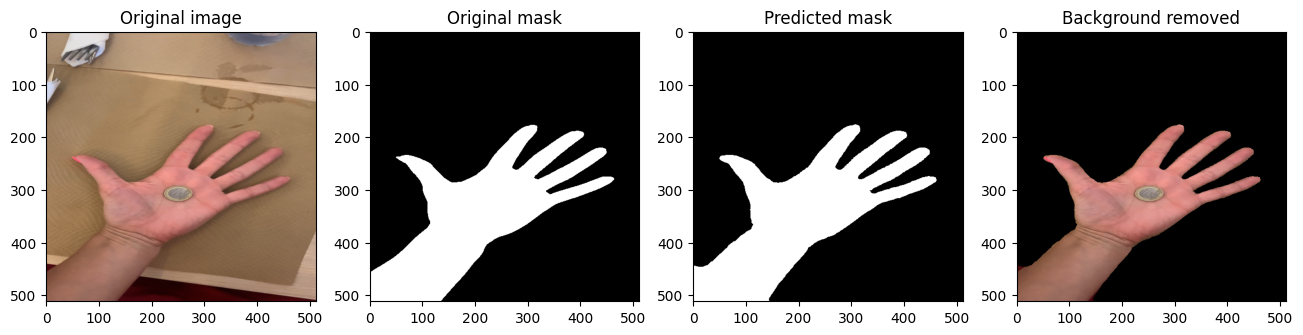

In [11]:
import matplotlib.pyplot as plt

# Valores de normalización usados en transforms.Normalize
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Visualización mejorada con desnormalización
def visualize_predictions_with_background_removal(model, dataloader, device, num_images=5):
    """
    Visualiza las predicciones del modelo y elimina el fondo con la máscara predicha.
    """
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Convertir logits a binario

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return
                
                # Desnormalizar imagen
                image_np = denormalize_image(images[i], imagenet_mean, imagenet_std)

                # Convertir máscara y predicción a numpy
                mask_np = masks[i].cpu().numpy().squeeze()
                pred_np = preds[i].cpu().numpy().squeeze()

                # Remover fondo utilizando la máscara predicha
                image_with_removed_bg = remove_background_with_predicted_mask(image_np, pred_np)

                # Graficar
                plt.figure(figsize=(16, 4))
                plt.subplot(1, 4, 1)
                plt.imshow(image_np)
                plt.title("Original image")
                
                plt.subplot(1, 4, 2)
                plt.imshow(mask_np, cmap="gray")
                plt.title("Original mask")
                
                plt.subplot(1, 4, 3)
                plt.imshow(pred_np, cmap="gray")
                plt.title("Predicted mask")
                
                plt.subplot(1, 4, 4)
                plt.imshow(image_with_removed_bg)
                plt.title("Background removed")
                
                plt.show()
                images_shown += 1



visualize_predictions_with_background_removal(model, dataloaders['test'], device)